In [1]:
#Do all of the imports and setup inline plotting
import time
import numpy as np
import gudhi as gd
from gudhi import wasserstein
%matplotlib widget

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


2022-05-26 17:30:36.327065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-26 17:30:36.327092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_matching(dgm1, dgm2, matching, axis):
    for pair in matching:
        if pair[0]==-1:
            point2 = dgm2[pair[1]]
            point1 = 0.5*np.sum(point2)*np.array([1,1])
        else:
            point1 = dgm1[pair[0]]
            if pair[1] == -1:
                point2 = 0.5*np.sum(point1)*np.array([1,1])
            else:
                point2 = dgm2[pair[1]]
        axis.plot((point1[0],point2[0]), (point1[1],point2[1]), color = "tab:green", alpha = 0.6)

In [3]:
def getLowerStarTimeSeriesPersistence(x):
    st = gd.SimplexTree()
    for i in range(0,len(x)):
        st.insert([i], x[i])
        if i < len(x)-1:
            st.insert([i,i+1], np.max([x[i], x[i+1]]))
    st.compute_persistence()
    dgm = st.persistence_intervals_in_dimension(0)
    return dgm

Elapsed time Wasserstein: 0.00113
Elapsed time Bottleneck: 0.00118


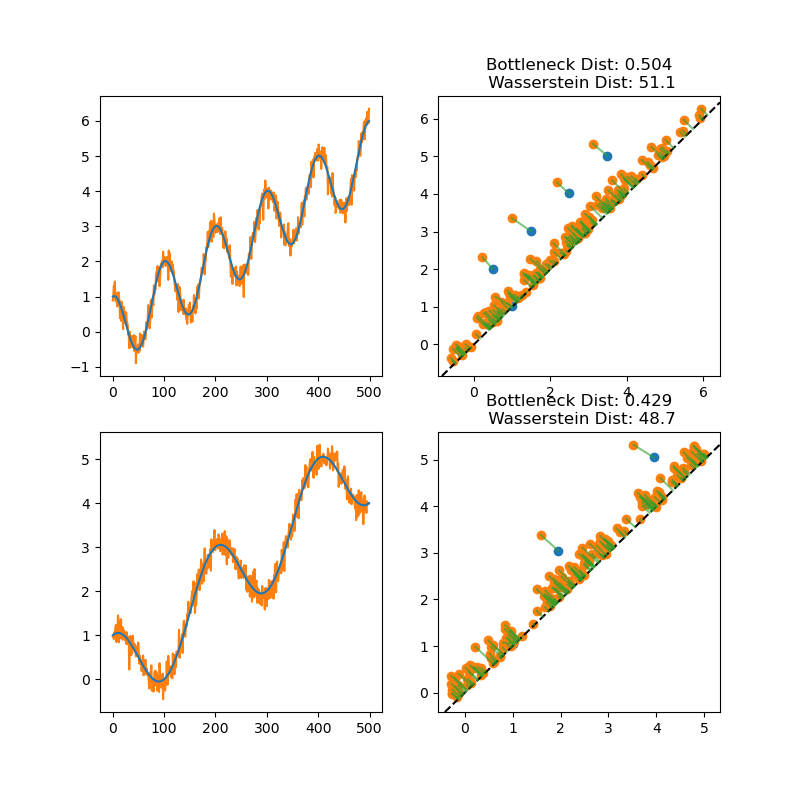

In [4]:
NSamples = 500
t = np.linspace(0, 5, NSamples)
x = np.cos(2*np.pi*t) + t
y = x + 0.2*np.random.randn(NSamples)

w = np.cos(np.pi*t) + t
z = w + 0.2*np.random.randn(NSamples)

Ix = getLowerStarTimeSeriesPersistence(x)
Iy = getLowerStarTimeSeriesPersistence(y)

Iw = getLowerStarTimeSeriesPersistence(w)
Iz = getLowerStarTimeSeriesPersistence(z)

f,ax = plt.subplots(2,2, figsize=(8, 8))
ax[0][0].plot(y, c = "tab:orange")
ax[0][0].plot(x, c = "tab:blue")

ax[1][0].plot(z, c="tab:orange")
ax[1][0].plot(w, c="tab:blue")



#Remove point at infinity before bottleneck/wasserstein
Ix = Ix[np.isfinite(Ix[:, 1]), :]
Iy = Iy[np.isfinite(Iy[:, 1]), :]

Iw = Iw[np.isfinite(Iw[:, 1]), :]
Iz = Iz[np.isfinite(Iz[:, 1]), :]

tic = time.time()
dw, wmatch = gd.wasserstein.wasserstein_distance(Ix, Iy, matching =True, order =1, internal_p =1)
print("Elapsed time Wasserstein: %.3g"%(time.time()-tic))
tic = time.time()
db = gd.bottleneck.bottleneck_distance(Ix, Iy)
print("Elapsed time Bottleneck: %.3g"%(time.time()-tic))
ax[0][1].set_title("Bottleneck Dist: %.3g\n Wasserstein Dist: %.3g"%(db,dw))
ax[0][1].scatter(Ix[:,0], Ix[:,1])
ax[0][1].scatter(Iy[:,0], Iy[:,1])
ax[0][1].axline((0,0), slope = 1, ls = "--", c="k")
plot_matching(Ix,Iy,wmatch, ax[0][1])


dw, wmatch = gd.wasserstein.wasserstein_distance(Iw, Iz, matching =True, order =1, internal_p =1)
db = gd.bottleneck.bottleneck_distance(Iw, Iz)

ax[1][1].set_title("Bottleneck Dist: %.3g\n Wasserstein Dist: %.3g"%(db,dw))
ax[1][1].scatter(Iw[:,0], Iw[:,1])
ax[1][1].scatter(Iz[:,0], Iz[:,1])
ax[1][1].axline((0,0), slope = 1, ls = "--", c="k")
plot_matching(Iw,Iz,wmatch, ax[1][1])

#ax[2].set_title("Wasserstein Dist: %.3g"%dw)

plt.show()

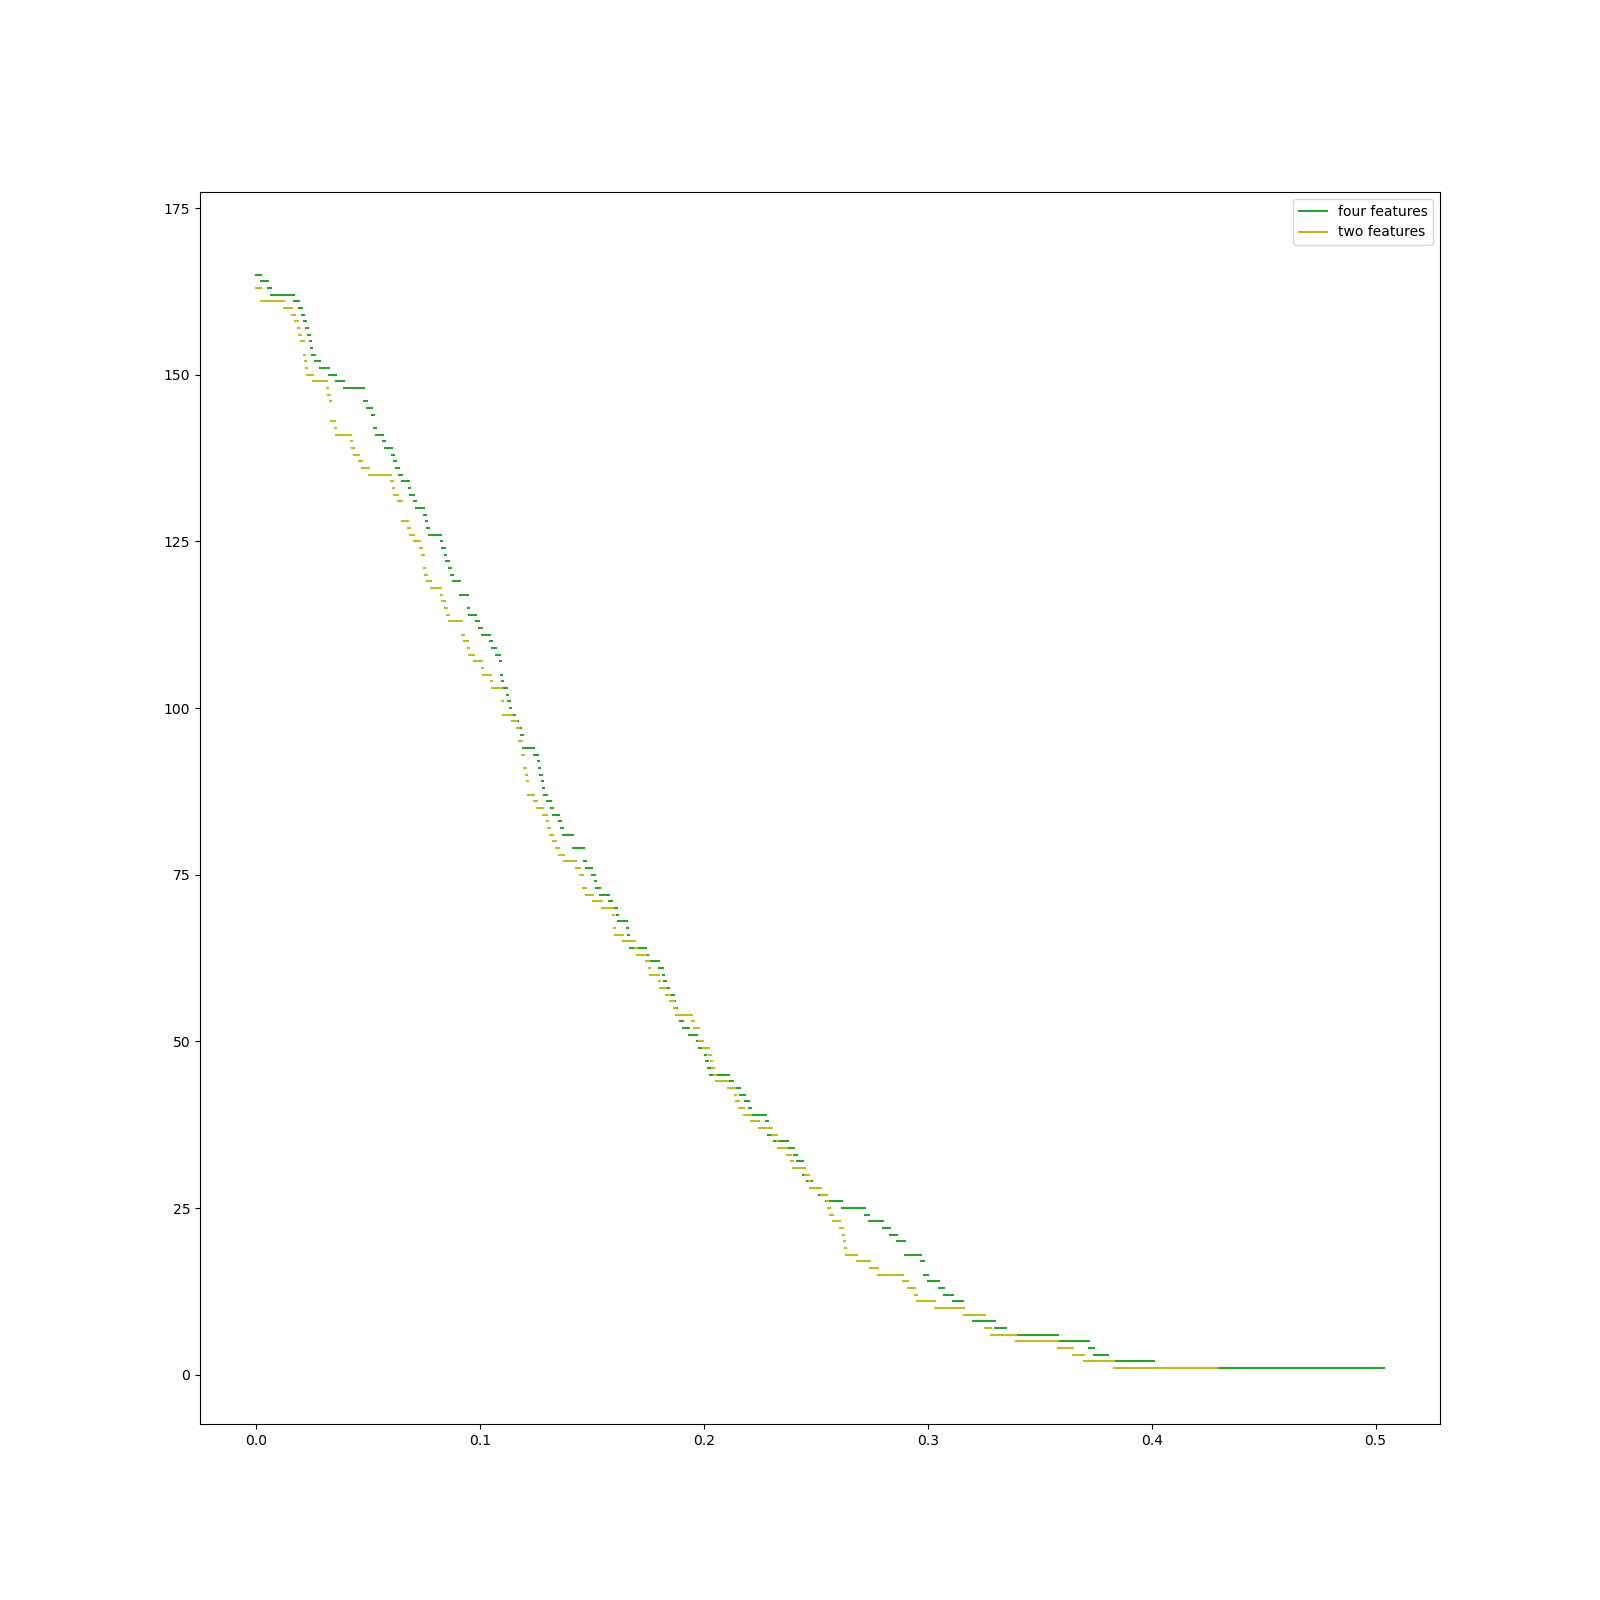

In [5]:
f,ax = plt.subplots(figsize = (16,16))
rvalsXY = [gd.prokhorov_distance(Ix, Iy, np.array([n])) for n in range(0,len(Ix)+len(Iy))]
rvalsWZ = [gd.prokhorov_distance(Iw, Iz, np.array([n])) for n in range(0,len(Iw)+len(Iz))]
for i in range(0,len(rvalsXY)-1):
    ax.plot((rvalsXY[i],rvalsXY[i+1]),(i+1,i+1), c= "tab:green", label ="four features")
for i in range(0,len(rvalsWZ)-1):
    ax.plot((rvalsWZ[i],rvalsWZ[i+1]),(i+1,i+1), c= "tab:olive", label = "two features")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))    
ax.legend(by_label.values(), by_label.keys())
plt.show()

In [6]:
NSamples = 500
MCIterations = 100
t = np.linspace(0, 5, NSamples)
bdistsXY = np.zeros(MCIterations)
wdistsXY = np.zeros(MCIterations)
bdistsWZ = np.zeros(MCIterations)
wdistsWZ = np.zeros(MCIterations)

rvalsXY =[]
rvalsWZ = []

for i in tqdm(range(0,MCIterations)):
    x = np.cos(2*np.pi*t) + t
    y = x + 0.1*np.random.randn(NSamples)

    w = np.cos(np.pi*t) + t
    z = w + 0.1*np.random.randn(NSamples)

    Ix = getLowerStarTimeSeriesPersistence(x)
    Iy = getLowerStarTimeSeriesPersistence(y)

    Iw = getLowerStarTimeSeriesPersistence(w)
    Iz = getLowerStarTimeSeriesPersistence(z)
    
    bdistsXY[i] = gd.bottleneck_distance(Ix, Iy)
    wdistsXY[i] = gd.wasserstein.wasserstein_distance(Ix, Iy, order = 1, internal_p = 1)
    bdistsWZ[i] = gd.bottleneck_distance(Iw, Iz)
    wdistsWZ[i] = gd.wasserstein.wasserstein_distance(Iw, Iz, order = 1, internal_p = 1)
    
    rvalsXY.append(np.array([gd.prokhorov_distance(Ix, Iy, np.array([n])) for n in range(0,len(Ix)+len(Iy))]))
    rvalsWZ.append(np.array([gd.prokhorov_distance(Iw, Iz, np.array([n])) for n in range(0,len(Iw)+len(Iz))]))
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
print("four sample bottleneck: mean = {} std = {}".format(np.mean(bdistsXY), np.std(bdistsXY)))
print("four sample wasserstein: mean = {} std = {}".format(np.mean(wdistsXY), np.std(wdistsXY)))
print("two sample bottleneck: mean = {} std = {}".format(np.mean(bdistsWZ), np.std(bdistsWZ)))
print("two sample wasserstein: mean = {} std = {}".format(np.mean(wdistsWZ), np.std(wdistsWZ)))

four sample bottleneck: mean = 0.24377430482718757 std = 0.03608252600684257
four sample wasserstein: mean = 19.634625722414995 std = 1.1757146998122858
two sample bottleneck: mean = 0.2530847627264249 std = 0.0376129318507781
two sample wasserstein: mean = 23.701836230307244 std = 1.0502174912569666


In [8]:
minlenWZ = np.min([len(arr) for arr in rvalsWZ])
MeanRvalsWZ = np.array([np.mean([arr[i] for arr in rvalsWZ]) for i in  range(0,minlenWZ)])
StdRvalsWZ = np.array([np.std([arr[i] for arr in rvalsWZ]) for i in  range(0,minlenWZ)])
minlenXY = np.min([len(arr) for arr in rvalsXY])
MeanRvalsXY = np.array([np.mean([arr[i] for arr in rvalsXY]) for i in  range(0,minlenXY)])
StdRvalsXY = np.array([np.std([arr[i] for arr in rvalsXY]) for i in  range(0,minlenXY)])

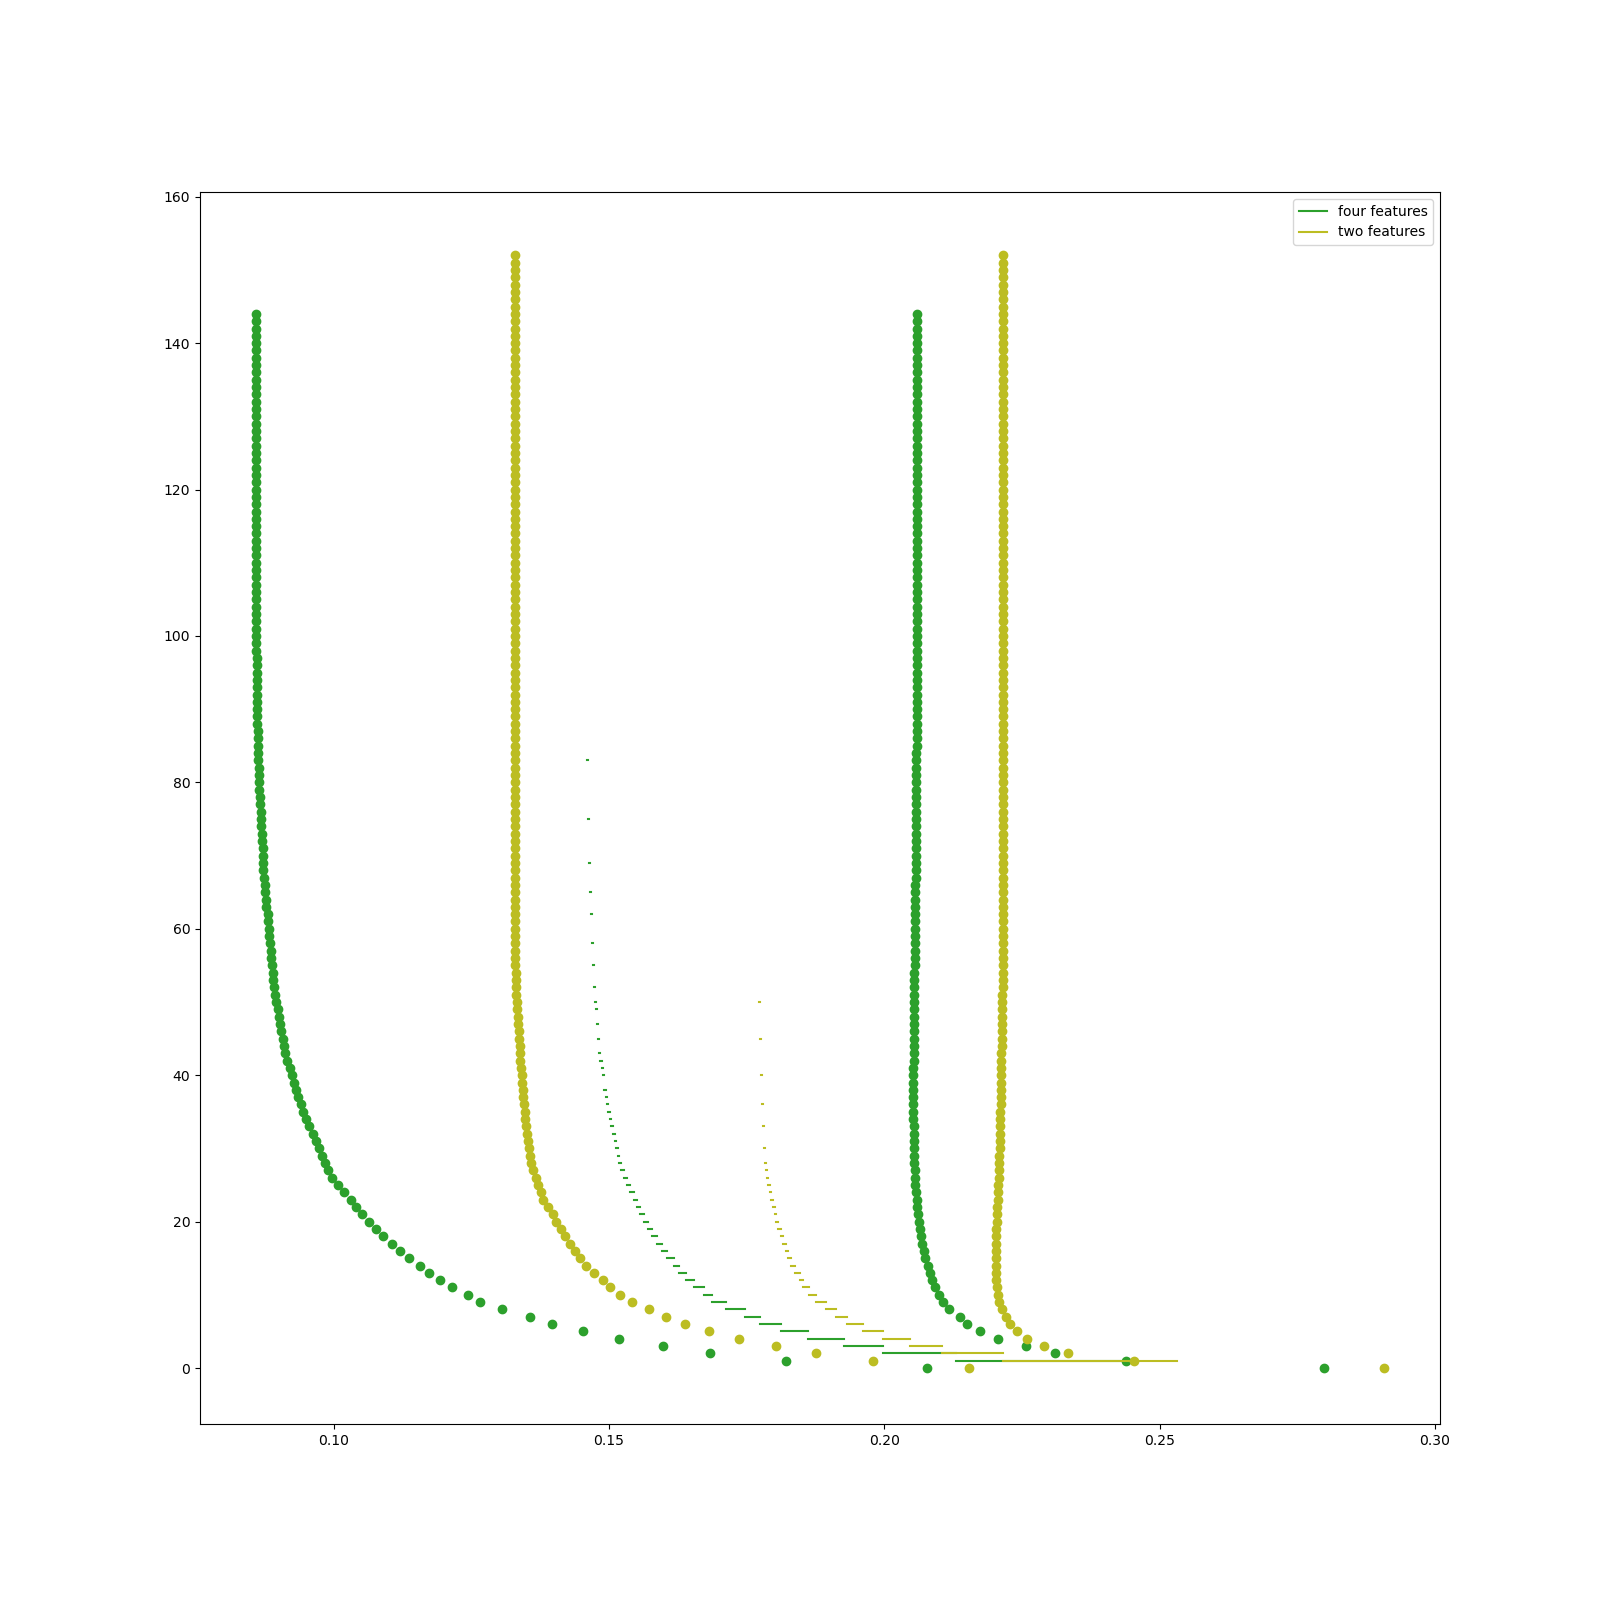

In [9]:
f,ax = plt.subplots(figsize = (16,16))

for i in range(0,len(MeanRvalsXY)-1):
    ax.plot((MeanRvalsXY[i],MeanRvalsXY[i+1]),(i+1,i+1), c= "tab:green", label ="four features")
    ax.scatter([MeanRvalsXY[i]-StdRvalsXY[i],MeanRvalsXY[i]+StdRvalsXY[i]],[i,i], c="tab:green")
for i in range(0,len(MeanRvalsWZ)-1):
    ax.plot((MeanRvalsWZ[i],MeanRvalsWZ[i+1]),(i+1,i+1), c= "tab:olive", label = "two features")
    ax.scatter([MeanRvalsWZ[i]-StdRvalsWZ[i],MeanRvalsWZ[i]+StdRvalsWZ[i]],[i,i], c="tab:olive")
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))    
ax.legend(by_label.values(), by_label.keys())
plt.show()

In [41]:
print(StdRvalsXY)
print(StdRvalsWZ)

[0.06608274 0.04282619 0.0369432  0.03919355 0.04306844 0.04531818
 0.04877384 0.05089851 0.05357    0.05613554 0.05887234 0.06014992
 0.06213105 0.06431949 0.06594753 0.06703601 0.06770728 0.06883391
 0.06981603 0.07054342 0.07176718 0.07238561 0.07328815 0.07419265
 0.07464715 0.075004   0.07554997 0.07594082 0.0764945  0.07692665
 0.07713255 0.07750014 0.07779018 0.0781469  0.07840882 0.07873658
 0.07899186 0.07928109 0.07948203 0.07972163 0.0799428  0.08014508
 0.08022724 0.08038868 0.08044854 0.08053229 0.08061782 0.08078493
 0.08089151 0.08096218 0.08103369 0.08114643 0.08132705 0.08138682
 0.08140912 0.0815143  0.08162976 0.08164751 0.08180974 0.08191672
 0.0820917  0.08217345 0.08224454 0.08226932 0.08236976 0.08241234
 0.08245187 0.08251102 0.08261768 0.08267084 0.08267863 0.08269686
 0.08270335 0.08270335 0.08270335 0.08270335 0.08270335 0.08270335
 0.08270335 0.08270335 0.08270335 0.08270335 0.08270335 0.08270335
 0.08270335 0.08270335 0.08270335 0.08270335 0.08270335 0.0827

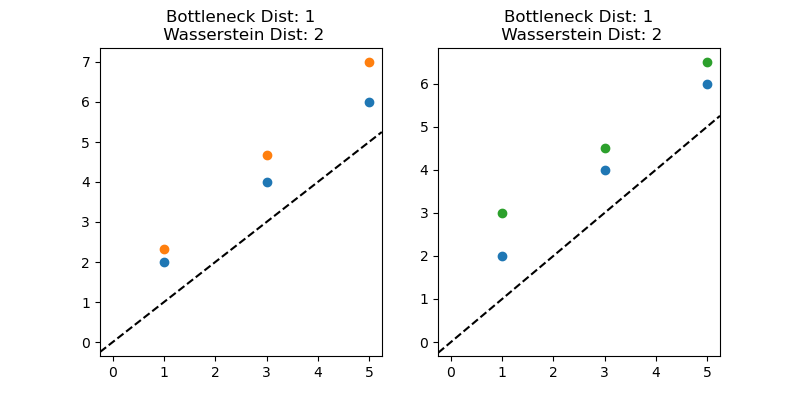

In [86]:
I1 = np.array([[1,2],[3,4],[5,6]])
I2 = np.array([[1,2+1/3],[3,4+2/3],[5,6+1]])
I3 = np.array([[1,2+1],[3,4+1/2],[5,6+1/2]])

f,ax=plt.subplots(1,2,figsize =(8,4))
ax[0].scatter(I1[:,0],I1[:,1])
ax[0].scatter(I2[:,0],I2[:,1])
ax[0].axline((0,0), slope = 1, ls = "--", c="k")
db = gd.bottleneck_distance(I1,I2)
dw = gd.wasserstein.wasserstein_distance(I1,I2, order =1, internal_p=1)

ax[0].set_title("Bottleneck Dist: %.3g\n Wasserstein Dist: %.3g"%(db,dw))


ax[1].scatter(I1[:,0],I1[:,1])
ax[1].scatter(I3[:,0],I3[:,1], c="tab:green")
ax[1].axline((0,0), slope = 1, ls = "--", c="k")
db = gd.bottleneck_distance(I1,I3)
dw = gd.wasserstein.wasserstein_distance(I1,I3, order =1, internal_p=1)

ax[1].set_title("Bottleneck Dist: %.3g\n Wasserstein Dist: %.3g"%(db,dw))
plt.show()

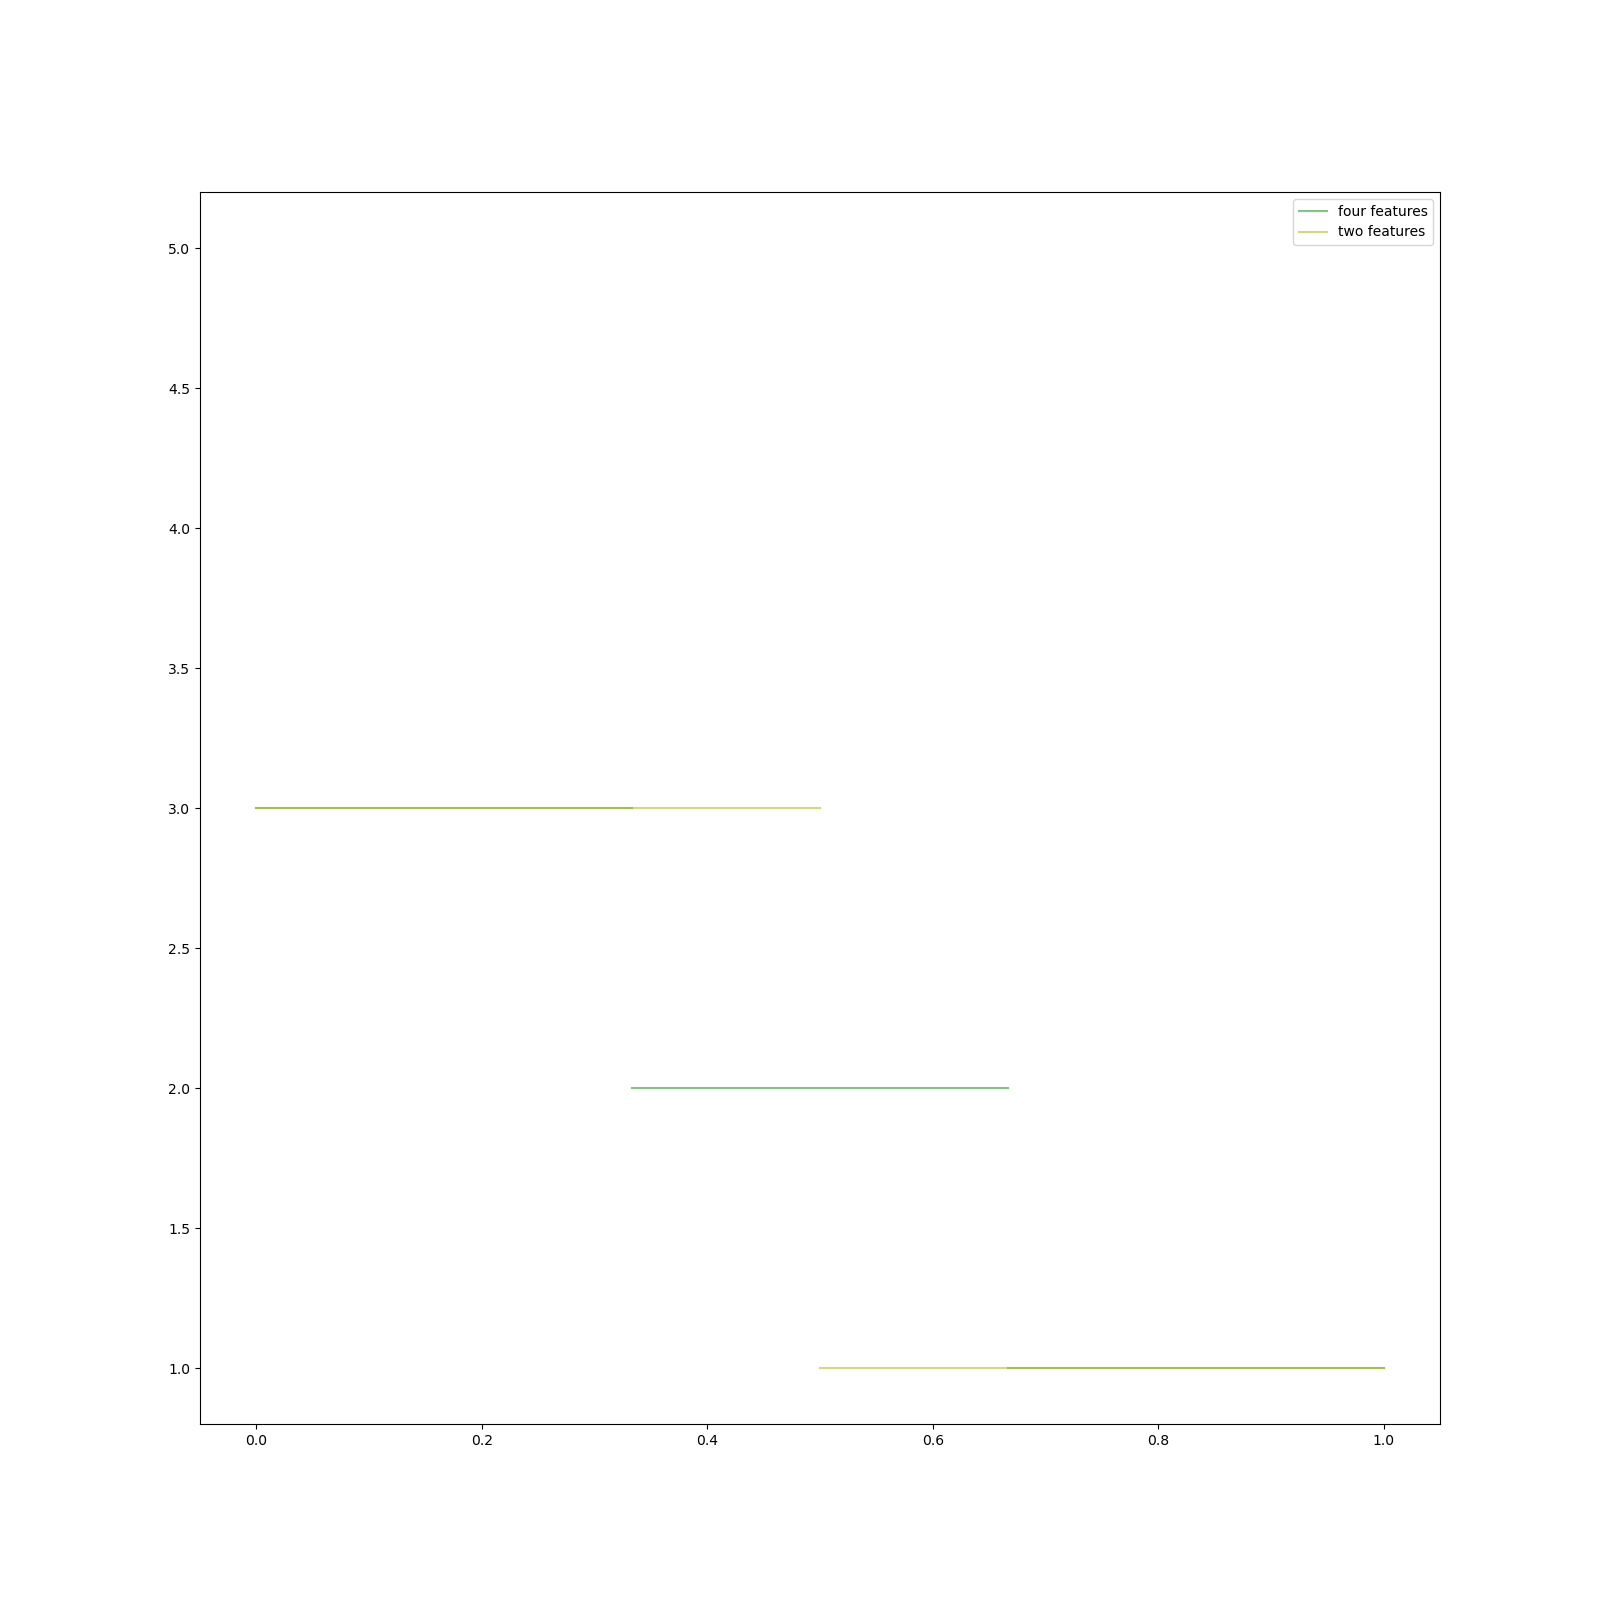

In [71]:
f,ax = plt.subplots(figsize = (16,16))
rvalsXY = [gd.prokhorov_distance(I1, I2, np.array([n])) for n in range(0,len(I1)+len(I2))]
rvalsWZ = [gd.prokhorov_distance(I1, I3, np.array([n])) for n in range(0,len(I1)+len(I3))]
for i in range(0,len(rvalsXY)-1):
    ax.plot((rvalsXY[i],rvalsXY[i+1]),(i+1,i+1), c= "tab:green", alpha = 0.6, label ="four features")
for i in range(0,len(rvalsWZ)-1):
    ax.plot((rvalsWZ[i],rvalsWZ[i+1]),(i+1,i+1), c= "tab:olive", alpha = 0.6, label = "two features")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))    
ax.legend(by_label.values(), by_label.keys())
plt.show()

In [76]:
print(gd.bottleneck_distance(I1,I2))
print(gd.bottleneck_distance(I1,I3))
print(gd.wasserstein.wasserstein_distance(I1,I2, matching=True, order =1, internal_p=1))
print(gd.wasserstein.wasserstein_distance(I1,I3, matching = True, order =1, internal_p=1))


1.0
1.0
(2.0000000000000004, array([[0, 0],
       [1, 1],
       [2, 2]]))
(2.0, array([[0, 0],
       [1, 1],
       [2, 2]]))
